In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

### 1. Get HTML and Handle Inconsistencies
#### Retrieve the HTML content of a given Wikipedia page and write code to manage different infobox structures. Use the Wikipedia page of "The Shape of Water" to start. Show a snippet of the page.

In [2]:
url = "https://en.wikipedia.org/wiki/The_Shape_of_Water"
response = requests.get(url)
html_content = response.text
print(html_content[:1000])

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-typography-survey-disabled vector-toc-available" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>The Shape of Water - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-cl

### 2. Get the info box and Manage Exceptions
#### a) Determine the CSS class or ID that targets the infobox and extract its HTML content. 

In [3]:
soup = BeautifulSoup(html_content, "html.parser")
infobox = soup.find(class_="infobox")
print(infobox.prettify())

<table class="infobox vevent">
 <tbody>
  <tr>
   <th class="infobox-above summary" colspan="2" style="font-size: 125%; font-style: italic;">
    The Shape of Water
   </th>
  </tr>
  <tr>
   <td class="infobox-image" colspan="2">
    <span class="mw-default-size mw-image-border" typeof="mw:File/Frameless">
     <a class="mw-file-description" href="/wiki/File:The_Shape_of_Water_(film).png" title="Underwater, a woman and a humanoid amphibian creature embrace.">
      <img alt="Underwater, a woman and a humanoid amphibian creature embrace." class="mw-file-element" data-file-height="326" data-file-width="220" decoding="async" height="326" src="//upload.wikimedia.org/wikipedia/en/3/37/The_Shape_of_Water_%28film%29.png" width="220"/>
     </a>
    </span>
    <div class="infobox-caption">
     Theatrical release poster
    </div>
   </td>
  </tr>
  <tr>
   <th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">
    Directed by
   </th>
   <td class="infobo

#### b) Write a function to handle exceptions such as missing information or alternative attribute names. For example, if "Box office" is not present, your function should be able to look for "Gross revenue".

In [4]:
def get_infobox_attribute(infobox, attribute):
    try:
        value = infobox.find("th", string=attribute).find_next_sibling("td").text.strip()
    except AttributeError:
        try:
            alternative_attribute = infobox.find("th", string=alternative_names[attribute])
            value = alternative_attribute.find_next_sibling("td").text.strip()
        except (AttributeError, KeyError):
            value = None
    return value

In [5]:
alternative_names = {"Box office": "Gross revenue"}
box_office_content = get_infobox_attribute(infobox, "Box office")
print("Box Office:", box_office_content)

Box Office: $195.3 million[5]


### 3. Create a Structured Data Frame
#### a) Parse the infobox HTML into a pandas DataFrame with columns labeled 'attribute' and 'value'. For example, box office would be the attribute with a value of 195.3 (in million USD).

In [6]:
data = []
for sup_tag in infobox.find_all('sup'):
    sup_tag.decompose()
for row in infobox.find_all("tr"):
    attribute = row.find("th")
    value = row.find("td")
    if attribute and value:
        data.append({"attribute": attribute.text.strip(), "value": value.text.strip()})
df = pd.DataFrame(data)
df

,attribute,value
0,Directed by,Guillermo del Toro
1,Screenplay by,Guillermo del Toro\nVanessa Taylor
2,Story by,Guillermo del Toro
3,Produced by,Guillermo del Toro\nJ. Miles Dale
4,Starring,Sally Hawkins\nMichael Shannon\nRichard Jenkin...
5,Cinematography,Dan Laustsen
6,Edited by,Sidney Wolinsky
7,Music by,Alexandre Desplat
8,Productioncompanies,Fox Searchlight PicturesTSG EntertainmentDoubl...
9,Distributed by,Fox Searchlight Pictures


#### b) Extract and clean the data for "Directed by", "Distributed by", "Running time", and "Box office", normalizing data formats (e.g., convert all running times to minutes). Consider standardizing currency for this exercise.

In [7]:
def get_value(df, attribute):
    if df[df["attribute"].str.contains(attribute, case=False, na=False)].empty:
        return None
    else:
        return df[df["attribute"].str.contains(attribute, case=False, na=False)]["value"].values[0]

def clean_currency(value):
    match = re.search(r'\$([\d,]+(?:\.\d+)?)\s*(million|billion)', value, re.I)
    if not match:
        return None
    amount, scale = match.groups()
    scale_multiplier = 1e6 if scale == 'million' else 1e9 if scale == 'billion' else 1
    amount = float(amount) * scale_multiplier
    return amount

def clean_runtime(value):
    match = re.search(r'(?:(\d+)\s*hours?)?\s*(?:(\d+)\s*minutes?)?', value, re.I)
    if not match:
        return None
    hours, minutes = match.groups()
    hours_to_minutes = int(hours) * 60 if hours else 0
    total_minutes = hours_to_minutes + (int(minutes) if minutes else 0)
    return total_minutes

directed_by = get_value(df, "Directed by")
distributed_by = get_value(df, "Distributed by")
box_office_value = get_value(df, "Box office")
running_time_value = get_value(df, "Running time")

box_office = clean_currency(box_office_value)
running_time = clean_runtime(running_time_value)

#### c) Ensure your code can export the DataFrame to a CSV file for persistent storage.

In [8]:
data = {
    'Directed by': directed_by,
    'Distributed by': distributed_by,
    'Box office(USD)': box_office,
    'Running time (minutes)': running_time,
}
cleaned_data = pd.DataFrame([data])
cleaned_data.to_csv('cleaned_data.csv', index=False)

### 4. Develop a Robust Scraping Function
#### Create a function called get_oscar_movie_info which:
#### a) Takes a Wikipedia URL as an input. b) Return a consistently formatted DataFrame. c) Include error handling for missing info and infobox variability. d) Saves the scraped data to a CSV file. e) Test this function with the pages for "Moonlight" and "Parasite" to ensure it handles various infobox layouts and missing data.

In [9]:
def get_oscar_movie_info(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    infobox = soup.find('table', class_='infobox')
    for sup_tag in infobox.find_all('sup'):
        sup_tag.decompose()
    if not infobox:
        raise ValueError("No infobox found")
    rows = infobox.find_all('tr')
    movie_info = {}
    
    for row in rows:
        if row.th and row.td: 
            attribute = row.th.text.strip()
            value = row.td.text.strip()
            if 'Running time' in attribute:
                value = clean_runtime(value)
            elif 'Box office' in attribute:
                value = clean_currency(value)
            movie_info[attribute] = value
            
    movie = pd.DataFrame(list(movie_info.items()), columns=['attribute', 'value'])
    movie.to_csv(url.split("/")[-1] + '_data.csv', index=False)
    return movie

In [10]:
moonlight_url = 'https://en.wikipedia.org/wiki/Moonlight_(2016_film)'
parasite_url = 'https://en.wikipedia.org/wiki/Parasite_(2019_film)'
moonlight_data = get_oscar_movie_info(moonlight_url)
parasite_data = get_oscar_movie_info(parasite_url)

### 5. Analyze All Best Picture Winners
#### a) Gather a list of Wikipedia URLs for all Best Picture winners from the list at List of Academy Award-winning films. 

In [23]:
url = "https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table", class_="wikitable")

rows = table.find_all("tr",{"style": "background:#EEDD82"})
urls = []
for row in rows:
    cells = row.find_all("td")
    film_cell = cells[0]
    link = film_cell.find("a")
    url = "https://en.wikipedia.org" + link["href"]
    urls.append(url)
print(urls)

['https://en.wikipedia.org/wiki/Everything_Everywhere_All_at_Once', 'https://en.wikipedia.org/wiki/CODA_(2021_film)', 'https://en.wikipedia.org/wiki/Nomadland_(film)', 'https://en.wikipedia.org/wiki/Parasite_(2019_film)', 'https://en.wikipedia.org/wiki/Green_Book_(film)', 'https://en.wikipedia.org/wiki/The_Shape_of_Water', 'https://en.wikipedia.org/wiki/Moonlight_(2016_film)', 'https://en.wikipedia.org/wiki/Spotlight_(film)', 'https://en.wikipedia.org/wiki/Birdman_(film)', 'https://en.wikipedia.org/wiki/12_Years_a_Slave_(film)', 'https://en.wikipedia.org/wiki/Argo_(2012_film)', 'https://en.wikipedia.org/wiki/The_Artist_(film)', 'https://en.wikipedia.org/wiki/The_King%27s_Speech', 'https://en.wikipedia.org/wiki/The_Hurt_Locker', 'https://en.wikipedia.org/wiki/Slumdog_Millionaire', 'https://en.wikipedia.org/wiki/No_Country_for_Old_Men_(film)', 'https://en.wikipedia.org/wiki/The_Departed', 'https://en.wikipedia.org/wiki/Crash_(2004_film)', 'https://en.wikipedia.org/wiki/Million_Dollar_Bab

#### b) Use your get_oscar_movie_info function in a loop to scrape and store data for each film.
#### c) Perform data normalization as needed during the scraping process.

In [52]:
def get_best_movie_info(url):
    try: 
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        infobox = soup.find('table', class_='infobox')
        if not infobox:
            raise ValueError("No infobox found")
            
        movie_info = {}
        movie_title = infobox.find('th', class_='infobox-above').get_text(strip=True) if infobox.find('th', class_='infobox-above') else soup.title.string.replace(' - Wikipedia', '').strip()
        for sup_tag in infobox.find_all('sup'):
            sup_tag.decompose()
        
        rows = infobox.find_all('tr') 
        for row in rows:
            header = row.find('th')
            value = row.find('td')
            if header and value: 
                attribute = header.text.strip()
                value = value.text.strip()
                if 'Running time' in attribute:
                    value = clean_runtime(value)
                elif 'Box office' in attribute:
                    value = clean_currency(value)
                movie_info[attribute] = value
        movie = pd.DataFrame(list(movie_info.items()), columns=['Attribute', 'Value'])
        movie['Movie Title'] = movie_title
        return movie
    
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return pd.DataFrame()

In [60]:
best_movie_data = []
for url in urls:
    film_info = get_best_movie_info(url)
    best_movie_data.append(film_info)

In [61]:
best_movie_all = pd.concat(best_movie_data, ignore_index=True)
best_movie_all.to_csv('best_movie_all.csv', index=False)

#### d) Analyze the dataset to identify which distributor has released the most Best Picture winners. Provide a plot of the length of the films over time.

In [85]:
wide = best_movie_all.pivot(index='Movie Title', columns='Attribute', values='Value')
wide.reset_index(inplace=True)
wide.head(5)

Attribute,Movie Title,Adaptation by,Based on,Box office,Budget,Cinematography,Color process,Countries,Country,Directed by,...,Productioncompany,Release date,Release dates,Revised Romanization,Running time,Screenplay by,Starring,Story by,Suggested by,Written by
0,12 Years a Slave,NaN,Twelve Years a Slaveby Solomon Northup,187700000.0,$20–22 million,Sean Bobbitt,NaN,United KingdomUnited StatesLuxembourg,NaN,Steve McQueen,...,NaN,NaN,"August 30, 2013 (2013-08-30) (Telluride Film F...",NaN,134,John Ridley,Chiwetel Ejiofor\nMichael Fassbender\nBenedict...,NaN,NaN,NaN
1,A Beautiful Mind,NaN,A Beautiful Mindby Sylvia Nasar,316800000.0,$58 million,Roger Deakins,NaN,NaN,United States,Ron Howard,...,NaN,NaN,"December 13, 2001 (2001-12-13) (Beverly Hills ...",NaN,135,NaN,Russell CroweEd HarrisJennifer ConnellyPaul Be...,NaN,NaN,Akiva Goldsman
2,A Man for All Seasons,NaN,A Man for All Seasons1960 playby Robert Bolt,28400000.0,$2 million,Ted Moore,NaN,NaN,United Kingdom,Fred Zinnemann,...,Highland Films,12 December 1966 (USA) March 1967 (UK),NaN,NaN,120,Robert Bolt,Paul Scofield\nWendy Hiller\nLeo McKern\nOrson...,NaN,NaN,NaN
3,All About Eve,NaN,"""The Wisdom of Eve""by Mary Orr",8400000.0,$1.4 million,Milton R. Krasner,NaN,NaN,United States,Joseph L. Mankiewicz,...,20th Century Fox,"October 13, 1950 (1950-10-13) (New York City)",NaN,NaN,138,Joseph L. Mankiewicz,Bette Davis\nAnne Baxter\nGeorge Sanders\nCele...,NaN,NaN,NaN
4,All Quiet on the Western Front,NaN,All Quiet on the Western Front1929 novelby Eri...,3000000.0,$1.2 million,Arthur Edeson,NaN,NaN,United States,Lewis Milestone,...,Universal Studios,"April 21, 1930 (1930-04-21) (US)",NaN,NaN,152,NaN,Lew AyresLouis Wolheim,NaN,NaN,Maxwell Anderson (adaptation & dialogue)\nGeor...


In [90]:
def extract_first_year(release_date_str):
    if isinstance(release_date_str, str):
        years = re.findall(r'\b([1-2]\d{3})\b', release_date_str)
        # extract the first release year as year
        return years[0] if years else None 
    return None
wide['Years'] = wide['Release dates'].apply(extract_first_year)
wide.head(5)

Attribute,Movie Title,Adaptation by,Based on,Box office,Budget,Cinematography,Color process,Countries,Country,Directed by,...,Release dates,Revised Romanization,Running time,Screenplay by,Starring,Story by,Suggested by,Written by,Years,Year
0,12 Years a Slave,NaN,Twelve Years a Slaveby Solomon Northup,187700000.0,$20–22 million,Sean Bobbitt,NaN,United KingdomUnited StatesLuxembourg,NaN,Steve McQueen,...,"August 30, 2013 (2013-08-30) (Telluride Film F...",NaN,134,John Ridley,Chiwetel Ejiofor\nMichael Fassbender\nBenedict...,NaN,NaN,NaN,2013,2013.0
1,A Beautiful Mind,NaN,A Beautiful Mindby Sylvia Nasar,316800000.0,$58 million,Roger Deakins,NaN,NaN,United States,Ron Howard,...,"December 13, 2001 (2001-12-13) (Beverly Hills ...",NaN,135,NaN,Russell CroweEd HarrisJennifer ConnellyPaul Be...,NaN,NaN,Akiva Goldsman,2001,2001.0
2,A Man for All Seasons,NaN,A Man for All Seasons1960 playby Robert Bolt,28400000.0,$2 million,Ted Moore,NaN,NaN,United Kingdom,Fred Zinnemann,...,NaN,NaN,120,Robert Bolt,Paul Scofield\nWendy Hiller\nLeo McKern\nOrson...,NaN,NaN,NaN,None,NaN
3,All About Eve,NaN,"""The Wisdom of Eve""by Mary Orr",8400000.0,$1.4 million,Milton R. Krasner,NaN,NaN,United States,Joseph L. Mankiewicz,...,NaN,NaN,138,Joseph L. Mankiewicz,Bette Davis\nAnne Baxter\nGeorge Sanders\nCele...,NaN,NaN,NaN,None,NaN
4,All Quiet on the Western Front,NaN,All Quiet on the Western Front1929 novelby Eri...,3000000.0,$1.2 million,Arthur Edeson,NaN,NaN,United States,Lewis Milestone,...,NaN,NaN,152,NaN,Lew AyresLouis Wolheim,NaN,NaN,Maxwell Anderson (adaptation & dialogue)\nGeor...,None,NaN


In [91]:
distributor_counts = wide['Distributed by'].value_counts()
top_distributor = distributor_counts.idxmax()
top__count = distributor_counts.max()
print(f"The distributor with the most Best Picture winners is {top_distributor} with {top__count} films.")

The distributor with the most Best Picture winners is Columbia Pictures with 10 films.


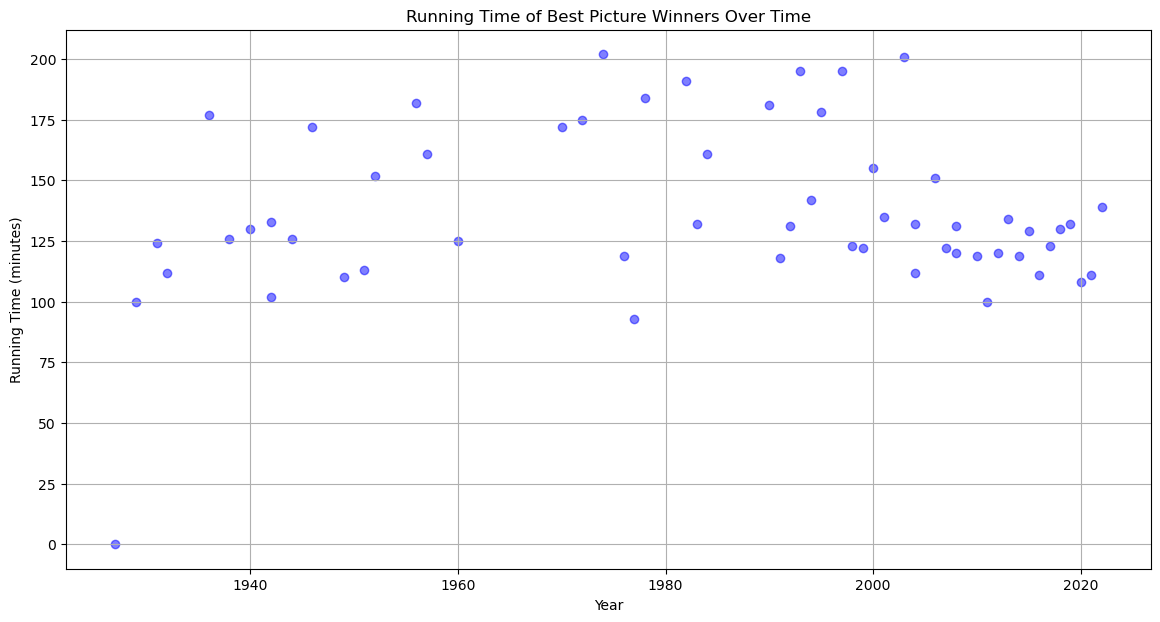

In [92]:
import matplotlib.pyplot as plt
wide['Years'] = pd.to_numeric(wide['Years'])
plt.figure(figsize=(14, 7))
plt.scatter(wide['Years'], wide['Running time'], color='blue', alpha=0.5)
plt.title('Running Time of Best Picture Winners Over Time')
plt.xlabel('Year')
plt.ylabel('Running Time (minutes)')
plt.grid(True)
plt.show()